# torch.nn简介

pytorch提供了很多设计良好的modules和classed，torch.nn，torch.optim，和Dataset以及Dataloader 来帮助构建和训练神经网络。为了充分利用它们的能力并为自己的问题定制，需要真正地理解它们都在做什么。首先只使用最基本的tensor的功能，然后逐步添加torch.nn, torch.optim, Dataset, or DataLoader的特性进去，展示每一块究竟在做什么，以及怎么能让代码更加简洁灵活。

在本小节，我们着重介绍nn.Module和nn.Linear。

## nn.Module类概述

torch.nn.Module类是所有神经网络模块(modules)的基类，它的实现在torch/nn/modules/module.py中。你的模型也应该继承这个类，主要重载__init__、forward和extra_repr函数。Modules还可以包含其它Modules，从而可以将它们嵌套在树结构中。

只要在自己的类中定义了forward函数，backward函数就会利用Autograd被自动实现。只要实例化一个对象并传入对应的参数就可以自动调用forward函数。因为此时会调用对象的__call__方法，而nn.Module类中的__call__方法会调用forward函数。

但有一些注意技巧：

（1）一般把网络中具有可学习参数的层（如全连接层、卷积层等）放在构造函数__init__()中，当然我也可以吧不具有参数的层也放在里面；

（2）一般把不具有可学习参数的层(如ReLU、dropout、BatchNormanation层)可放在构造函数中，也可不放在构造函数中，如果不放在构造函数__init__里面，则在forward方法里面可以使用nn.functional来代替
    
（3）forward方法是必须要重写的，它是实现模型的功能，实现各个层之间的连接关系的核心。
下面来看一个简单的例子：

In [1]:
import torch
 
class MyNet(torch.nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()  # 第一句话，调用父类的构造函数
        self.conv1 = torch.nn.Conv2d(3, 32, 3, 1, 1)
        self.relu1=torch.nn.ReLU()
        self.max_pooling1=torch.nn.MaxPool2d(2,1)
 
        self.conv2 = torch.nn.Conv2d(3, 32, 3, 1, 1)
        self.relu2=torch.nn.ReLU()
        self.max_pooling2=torch.nn.MaxPool2d(2,1)
 
        self.dense1 = torch.nn.Linear(32 * 3 * 3, 128)
        self.dense2 = torch.nn.Linear(128, 10)
 
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.max_pooling1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.max_pooling2(x)
        x = self.dense1(x)
        x = self.dense2(x)
        return x
 
model = MyNet()
print(model)

MyNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (max_pooling1): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (max_pooling2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (dense1): Linear(in_features=288, out_features=128, bias=True)
  (dense2): Linear(in_features=128, out_features=10, bias=True)
)


注意：上面的是将所有的层都放在了构造函数__init__里面，但是只是定义了一系列的层，各个层之间到底是什么连接关系并没有，而是在forward里面实现所有层的连接关系，当然这里依然是顺序连接的。下面再来看一下一个例子：

In [2]:
import torch
import torch.nn.functional as F
 
class MyNet(torch.nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()  # 第一句话，调用父类的构造函数
        self.conv1 = torch.nn.Conv2d(3, 32, 3, 1, 1)
        self.conv2 = torch.nn.Conv2d(3, 32, 3, 1, 1)
 
        self.dense1 = torch.nn.Linear(32 * 3 * 3, 128)
        self.dense2 = torch.nn.Linear(128, 10)
 
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x)
        x = self.dense1(x)
        x = self.dense2(x)
        return x
 
model = MyNet()
print(model)


MyNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dense1): Linear(in_features=288, out_features=128, bias=True)
  (dense2): Linear(in_features=128, out_features=10, bias=True)
)


注意：此时，将没有训练参数的层没有放在构造函数里面了，所以这些层就不会出现在model里面，但是运行关系是在forward里面通过functional的方法实现的。因此，所有放在构造函数__init__里面的层的都是这个模型的“固有属性”.

## nn.Linear概述

PyTorch的nn.Linear（）是用于设置网络中的全连接层的，需要注意在二维图像处理的任务中，全连接层的输入与输出一般都设置为二维张量，形状通常为[batch_size, size]，不同于卷积层要求输入输出是四维张量。其用法与形参说明如下：
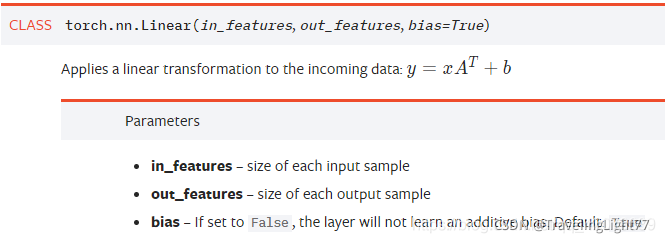

### 参数说明
- in_features指的是输入的二维张量的大小，即输入的 [batch_size, size] 中的size（输入图片的特征共有多少个，上一个全连接层神经元的个数）。

- out_features指的是输出的二维张量的大小，即输出的二维张量的形状为[batch_size，output_size]，当然，它也代表了该全连接层的神经元个数。

- Linear其实就是对输入 X<sub>n×i</sub>执行了一个线性变换，即：Y<sub>n×o</sub> = X<sub>n×i</sub>W<sub>i×o</sub> + b ，其中W是模型要学习的参数，W的维度为 W <sub>i×o</sub>，b是o维的向量偏置，n为输入向量的行数（例如，你想一次输入10个样本，即batch_size为10，则n = 10 ），i为输入神经元的个数（例如你的样本特征数为5，则i = 5），o为输出神经元的个数。

从输入输出的张量的shape角度来理解，相当于一个输入为[batch_size, in_features]的张量变换成了[batch_size, out_features]的输出张量。

### 简单示例

In [3]:
import torch as t
from torch import nn

# in_features由输入张量的形状决定，out_features则决定了输出张量的形状 
connected_layer = nn.Linear(in_features = 64*64*3, out_features = 1)

# 假定输入的图像形状为[64,64,3]
input = t.randn(1,64,64,3)

# 将四维张量转换为二维张量之后，才能作为全连接层的输入
input = input.view(1,64*64*3)
print(input.shape)
output = connected_layer(input) # 调用全连接层
print(output.shape)


torch.Size([1, 12288])
torch.Size([1, 1])


总结：
- pytorch里面一切自定义操作基本上都是继承nn.Module类来实现的。
- Linear其实就是对输入 X<sub>n×i</sub>执行了一个线性变换，即 y = xA<sup>T</sup> + b 。

